In [1]:
# #!/bin/bash
# !curl -L -o ~/Downloads/sea-animals-image-dataste.zip\
#     https://www.kaggle.com/api/v1/datasets/download/vencerlanz09/sea-animals-image-dataste

In [2]:
dir = '/Users/coldbrew/Documents/SKT_FLY/2주차/sea-animals-image-dataste'

In [3]:
import os
import pandas as pd
import cv2
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="cv2")
def create_dataset_with_paths(directory):
    dataset = []
    labels = os.listdir(directory)
    for label in labels:
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                if os.path.isfile(file_path):
                    # 이미지 경로와 레이블만 추가
                    dataset.append((file_path, label))
    return pd.DataFrame(dataset, columns=['path', 'label'])


dir = '/Users/coldbrew/Documents/SKT_FLY/2주차/sea-animals-image-dataste'
datasets = create_dataset_with_paths(dir)
print(datasets.head())

                                                path     label
0  /Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...  Seahorse
1  /Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...  Seahorse
2  /Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...  Seahorse
3  /Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...  Seahorse
4  /Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...  Seahorse


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


In [5]:
datasets.shape

(13711, 2)

In [6]:
datasets

,path,label
0,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Seahorse
1,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Seahorse
2,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Seahorse
3,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Seahorse
4,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Seahorse
...,...,...
13706,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Nudibranchs
13707,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Nudibranchs
13708,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Nudibranchs
13709,/Users/coldbrew/Documents/SKT_FLY/2주차/sea-anim...,Nudibranchs


In [7]:
images = np.array(datasets['path']) 
images.shape

(13711,)

In [8]:
# 이미지 데이터를 리스트에서 넘파이 배열로 변환
labels = np.array(datasets['label'])
len(labels)

13711

In [9]:
len(set(labels))

23

In [10]:
# # 레이블 알파벳 순으로 정렬
# unique_labels = sorted(list(set(labels)))  # <-- 핵심: 알파벳 순 정렬
# print(unique_labels, end='\n')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# print(label_to_index, end='\n')
# # 정수 인코딩
# indexed_labels = np.array([label_to_index[label] for label in labels])
# print(indexed_labels, end='\n')


In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    datasets['path'],
    datasets['label'],
    test_size=0.3,
    random_state=42,
    stratify=datasets['label']  # 클래스 비율 유지
)

# 임시 세트의 50%를 검증, 50%를 테스트 세트로 분할 (전체의 15%씩)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# DataFrame으로 변환
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
val_df = pd.DataFrame({'path': X_val, 'label': y_val})
test_df = pd.DataFrame({'path': X_test, 'label': y_test})

print("학습 세트 크기:", train_df.shape)
print("검증 세트 크기:", val_df.shape)
print("테스트 세트 크기:", test_df.shape)

학습 세트 크기: (9597, 2)
검증 세트 크기: (2057, 2)
테스트 세트 크기: (2057, 2)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 학습용 어그멘테이션 및 정규화
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, 
    rescale=1./255  # 픽셀값 [0,1] 범위로 정규화
)

# 검증용에는 최소한의 변환(정규화만) 적용
val_datagen = ImageDataGenerator(rescale=1./255)


In [13]:
batch_size = 32
target_size = (128, 128)

train_generator = train_datagen.flow_from_dataframe( # 자동으로 이미지를 읽어서 전처리까지 해줌
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=target_size,
    class_mode='sparse',  # 정수 라벨을 그대로 사용
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=target_size,
    class_mode='sparse',  # 정수 라벨
    batch_size=batch_size,
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=target_size,
    class_mode='sparse',  # 정수 라벨 사용
    batch_size=batch_size,
    shuffle=False,
)

print("Classes:", train_generator.class_indices)

Found 9597 validated image filenames belonging to 23 classes.
Found 2057 validated image filenames belonging to 23 classes.
Found 2057 validated image filenames belonging to 23 classes.
Classes: {'Clams': 0, 'Corals': 1, 'Crabs': 2, 'Dolphin': 3, 'Eel': 4, 'Fish': 5, 'Jelly Fish': 6, 'Lobster': 7, 'Nudibranchs': 8, 'Octopus': 9, 'Otter': 10, 'Penguin': 11, 'Puffers': 12, 'Sea Rays': 13, 'Sea Urchins': 14, 'Seahorse': 15, 'Seal': 16, 'Sharks': 17, 'Shrimp': 18, 'Squid': 19, 'Starfish': 20, 'Turtle_Tortoise': 21, 'Whale': 22}


In [ ]:

# CNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(23, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/Users/coldbrew/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-03 00:00:24.396328: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-03 00:00:24.396354: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-01-03 00:00:24.396361: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-01-03 00:00:24.396376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-03 00:00:24.396386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_facto

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,077,079 (99.48 MB)

 Trainable params: 26,075,159 (99.47 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

In [16]:
print(f"Train samples: {train_generator.samples}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {train_generator.samples // batch_size}")
print(f"Validation steps: {val_generator.samples // batch_size}")

Train samples: 9597
Batch size: 32
Steps per epoch: 299
Validation steps: 64


In [17]:
# 에폭 수 설정
epochs = 50

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    # callbacks=[live_plot]
)

Epoch 1/50


/Users/coldbrew/miniconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-03 00:00:25.468636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 150ms/step - accuracy: 0.1677 - loss: 3.4373 - val_accuracy: 0.1716 - val_loss: 3.1447
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.2436 - loss: 2.7566 - val_accuracy: 0.2888 - val_loss: 2.3413
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 145ms/step - accuracy: 0.2710 - loss: 2.6083 - val_accuracy: 0.2781 - val_loss: 2.7678
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.2976 - loss: 2.4279 - val_accuracy: 0.3019 - val_loss: 2.4584
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3183 - loss: 2.3855 - val_accuracy: 0.3238 - val_loss: 2.4795
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.3285 - loss: 2.3184 - val_accuracy: 0.3374 - val_loss: 2.4180
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.3403 - loss: 2.2254 - val_accuracy: 0.3379 - val_loss: 2.4915
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.3535 - loss: 2.1941 - val

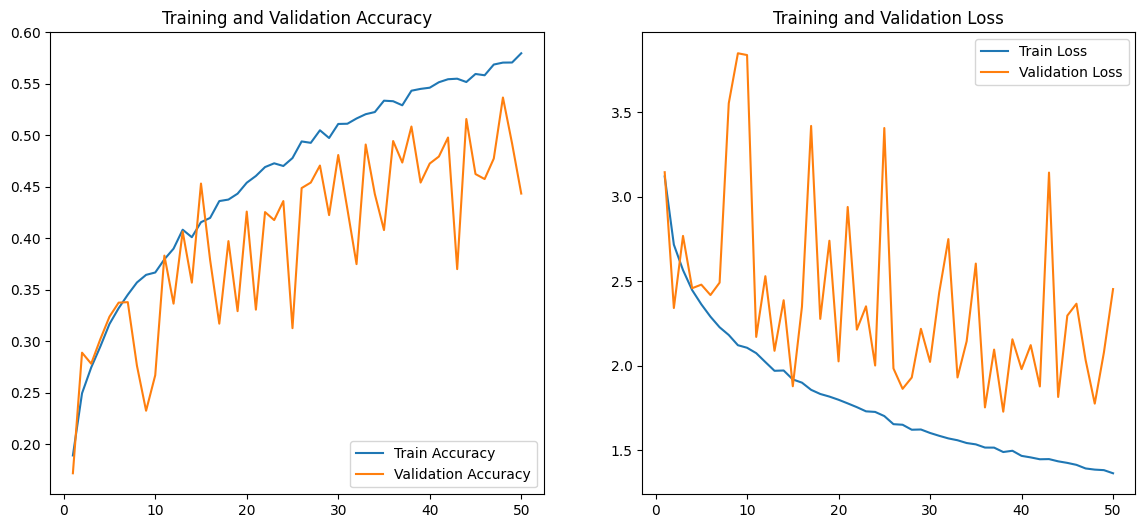

In [18]:
import matplotlib.pyplot as plt

# 학습 기록에서 데이터 추출
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

# 정확도 그래프
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4283 - loss: 2.5330
loss, acc :  [2.4830803871154785, 0.42926591634750366]


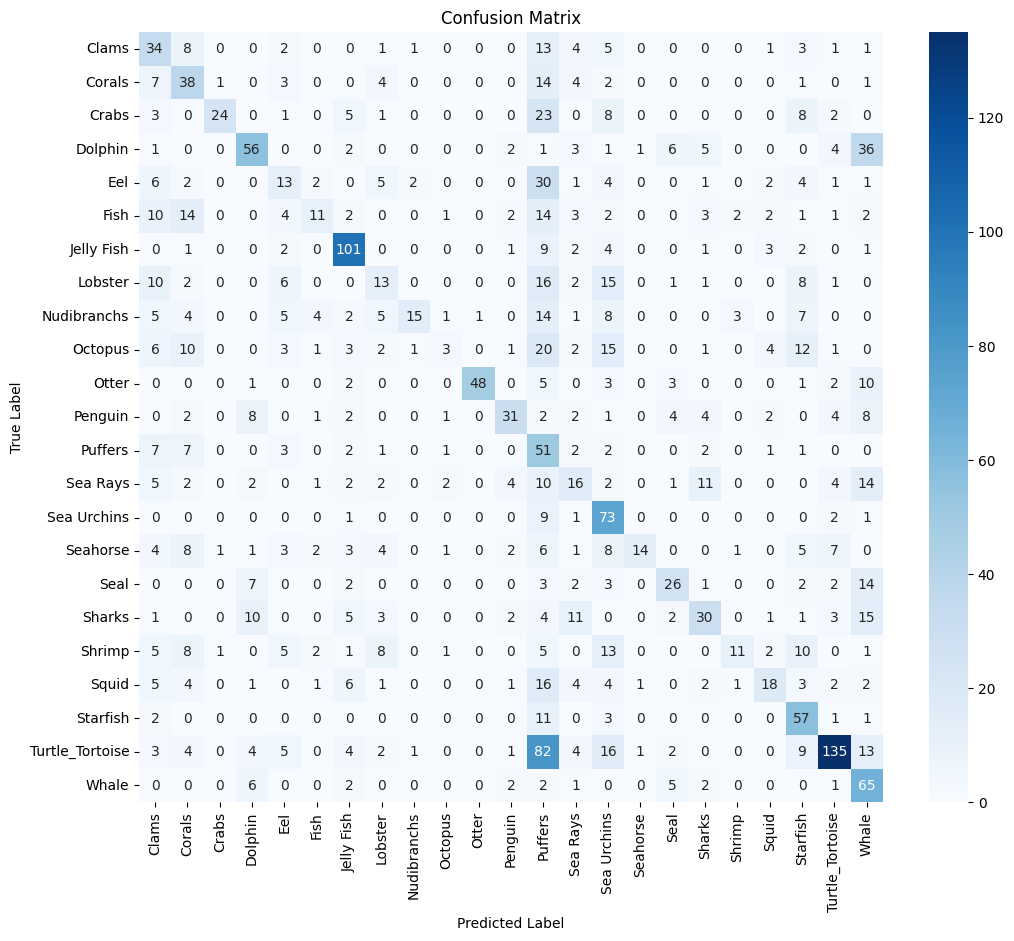

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 검증 세트에 대한 예측
test_generator.reset()
steps = int(np.ceil(test_generator.samples / batch_size))
predictions = model.predict(test_generator, steps=steps)
print("loss, acc : ", model.evaluate(test_generator, steps=steps))
predicted_classes = np.argmax(predictions, axis=1)

# 실제 라벨
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 혼동 행렬 계산
cm = confusion_matrix(true_classes, predicted_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()